# Exam Preparation: SABR

## Setup

In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.special import ndtr

# local 
import fixed_income_derivatives as fid

In the SABR model, the forward rate denoted $F_t$, typically a forward par swap rate, follows a stochastic process with stochastic volatility $\sigma_t$. The joint dynamics of $F_t$ and $\sigma_t$
$$
\begin{aligned}
d F_t & =\sigma_t^\beta F_t d W_t^{(1)}, & & F(0)=F_0 \\
d \sigma_t & =v \sigma_t d W_t^{(2)}, & & \sigma(0)=\sigma_0 \\
d W_t^{(1)} d W_t^{(2)} & =\rho & &
\end{aligned}
$$
where $\sigma_0>0,0<\beta \leq 1, v>0$ and $-1<\rho<1$ are parameters of the model. \
**Zero coupon bond prices** observed from market data are given in the below table.

\begin{array}{|c|c|c|c|c|c|c|c|}
\hline T & 0.50 & 1.00 & 1.50 & 2.00 & 2.50 & 3.00 & 3.50 \\
\hline p(0, T) & 0.98429046 & 0.96633686 & 0.94690318 & 0.92655036 & 0.90568659 & 0.88460647 & 0.86352084 \\
\hline \hline T & 4.00 & 4.50 & 5.00 & 5.50 & 6.00 & 6.50 & 7.00 \\
\hline p(0, T) & 0.84257919 & 0.82188628 & 0.80151436 & 0.78151217 & 0.76191149 & 0.74273188 & 0.72398415 \\
\hline
\end{array}

Also, we can observe prices of $2 \mathrm{Y} 5 \mathrm{Y}$ payer swaptions for a number of strike offsets.

\begin{aligned}
&\text { Table 2: 2Y5Y Swaption prices }\\
&\begin{array}{|c|c|c|c|c|c|c|c|}
\hline K_{\text {offset }}(b p) & -300 & -250 & -200 & -150 & -100 & -50 & \text { ATMF } \\
\hline \Pi_{\text {swaption }} & **0.12301549** & 0.10339456 & 0.08421278 & 0.06567338 & 0.04843543 & 0.03300976 & 0.02048677 \\
\hline \hline K_{\text {offset }}(b p) & 50 & 100 & 150 & 200 & 250 & 300 & - \\
\hline \Pi_{\text {swaption }} & 0.01173834 & 0.00648577 & 0.00361682 & 0.00215934 & 0.00137503 & 0.00093634 & - \\
\hline
\end{array}
\end{aligned}

If you want to buy swaption at strike offset of -300 and you want to shop notional of 100m it will - cost you 12M. Offset is 3 pct.point below the 2Y5Y par swap rate.

## Forward Par Swap Rate

In [3]:
alpha = 0.5
T_max = 7
idx_exer, idx_mat = 4, 14 # 2Y5Y Forward Swap rate T_n = 2, T_N=7
K_swaption_offset = [-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300]
N_swaption = len(K_swaption_offset)
M = int(round(T_max/alpha)+1)
T = np.array([i*alpha for i in range(0,M)])
p = np.array([1, 0.98429046, 0.96633686, 0.94690318, 0.92655036, 0.90568659, 0.88460647, 0.86352084, 0.84257919, 0.82188628, 0.80151436, 0.78151217, 0.76191149, 0.74273188, 0.72398415])
price_market = np.array([0.12301549, 0.10339456, 0.08421278, 0.06567338, 0.04843543, 0.03300976, 0.02048677, 0.01173834, 0.00648577, 0.00361682, 0.00215934, 0.00137503, 0.00093634])

**Compute Accrual Factor**

In [4]:
S_swap = 0
for i in range(idx_exer+1,idx_mat + 1):
    S_swap += alpha*p[i]

**Compute 2Y5Y Par swap rate**

In [5]:
R_swap = (p[idx_exer] - p[idx_mat])/S_swap
print(f"accrual factor: {S_swap}, 2Y5Y par swap rate: {R_swap}")

accrual factor: 4.06496671, 2Y5Y par swap rate: 0.04983219407472096


We get a accrual factor of 4 which is reasonable for a 5y maturtiy, this is also a sanity check: should be close to maturity!

**Compute Black Implied Volatilities for All Strikes**

In [6]:
# remember to adjust iv0, initial guess of iv, if we get NaN
K, iv_market = np.zeros([N_swaption]), np.zeros([N_swaption])
for i in range(0,N_swaption):
    K[i] = R_swap + K_swaption_offset[i]/10000
    iv_market[i] = fid.black_swaption_iv(price_market[i],T[idx_exer],K[i],S_swap,R_swap,type = "call", iv0 = 0.25, max_iter = 1000, prec = 1.0e-12)
print(iv_market)

[0.37271288 0.32282708 0.28265711 0.24785851 0.22072556 0.19726113
 0.17974193 0.16969789 0.16614408 0.16689728 0.17143419 0.17752206
 0.18457536]


**Plot of market implied volatilities**

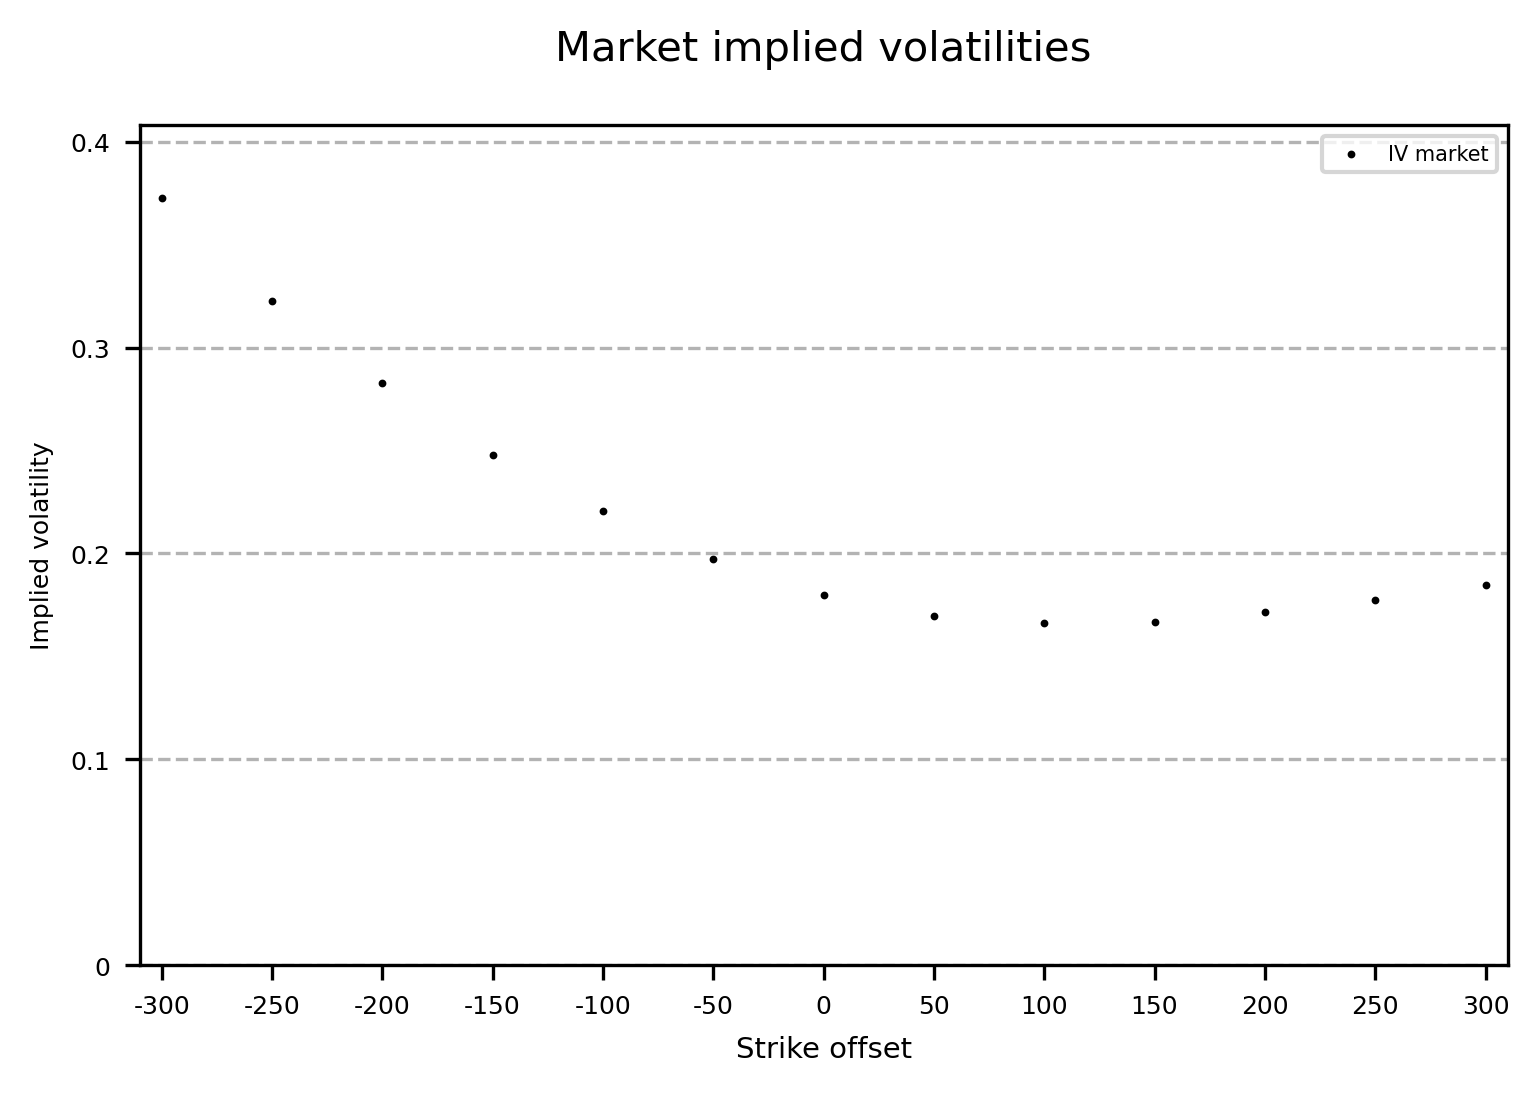

In [7]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))
fig.suptitle(f"Market implied volatilities", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = K_swaption_offset
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-10,xticks[-1]+10])
plt.xlabel(f"Strike offset",fontsize = 7)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels([0,0.1,0.2,0.3,0.4],fontsize = 6)
ax.set_ylim([0,0.408])
# plt.ylabel(f"Delta",fontsize = 7)
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Implied volatility",fontsize = 6)
p1 = ax.scatter(K_swaption_offset, iv_market, s = 3, color = 'black', marker = ".",label="IV market")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

- We can see from the plot of market implied volatilities and the fact that implied volatility is not constant for all strikes that the market is not pricing $2 \mathrm{Y} 5 \mathrm{Y}$ payer swaptions according to Black's formula. 
     - That the market is not using Blacks formula (smirk and not flat, i.e. not independent of strike prices) motivates the use of SABR model
- The 'fat' tails both on the left and the right indicate that the distribution of the underlying asset implied by market swaption prices have tails that are fatter than that of the log-normal distribution. Also, the fact that the slope of the smile is negative ATM and that the left tail is more pronounced than the right suggests that the distribution of the underlying implied by market prices is asymmetric with more weight placed in the left tail.

## Fitting the SABR Model

You are now to fit a SABR model to observed implied volatilities setting initial values $\tilde{\sigma}_0=0.055$, $\tilde{\beta}=0.5, \tilde{v}=0.48$ and $\tilde{\rho}=-0.25$ and the 'nelder-mead' algorithm.

**Fitting the model**

In [8]:
# initial guess per assignment text
param_0 = 0.03, 0.5, 0.4,-0.3 

# run optimizer
result = minimize(fid.fit_sabr_obj,param_0,method = 'nelder-mead',args = (iv_market,K,T[idx_exer],R_swap),options={'xatol': 1e-8,'disp': True})
print(f"Parameters from fit: {result.x}, squared dev: {result.fun}")
sigma_0, beta, upsilon, rho = result.x

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 441
         Function evaluations: 744
Parameters from fit: [ 0.0379421   0.49411122  0.57359064 -0.32175924], squared dev: 2.09783864422823e-06


In [9]:
iv_fit, price_fit = np.zeros([N_swaption]), np.zeros([N_swaption])
for i in range(0,N_swaption):
    iv_fit[i] = fid.sigma_sabr(K[i],T[idx_exer],R_swap,sigma_0,beta,upsilon,rho,type = "call")
    price_fit[i] = fid.black_swaption_price(iv_fit[i],T[idx_exer],K[i],S_swap,R_swap,type = "call")
print(f"Parameters from the fit: sigma_0: {sigma_0}, beta: {beta}, upsilon: {upsilon}, rho: {rho}")
print(f"Implied volatilities from market prices:")
print(iv_fit)

Parameters from the fit: sigma_0: 0.037942103964370824, beta: 0.4941112222670978, upsilon: 0.5735906382289708, rho: -0.32175923812947876
Implied volatilities from market prices:
[0.37247181 0.32300549 0.28259141 0.24870706 0.22021729 0.196992
 0.179755   0.16947376 0.16597348 0.16746727 0.17183954 0.17761341
 0.1839624 ]


**Plot of Market and Fitted IV**

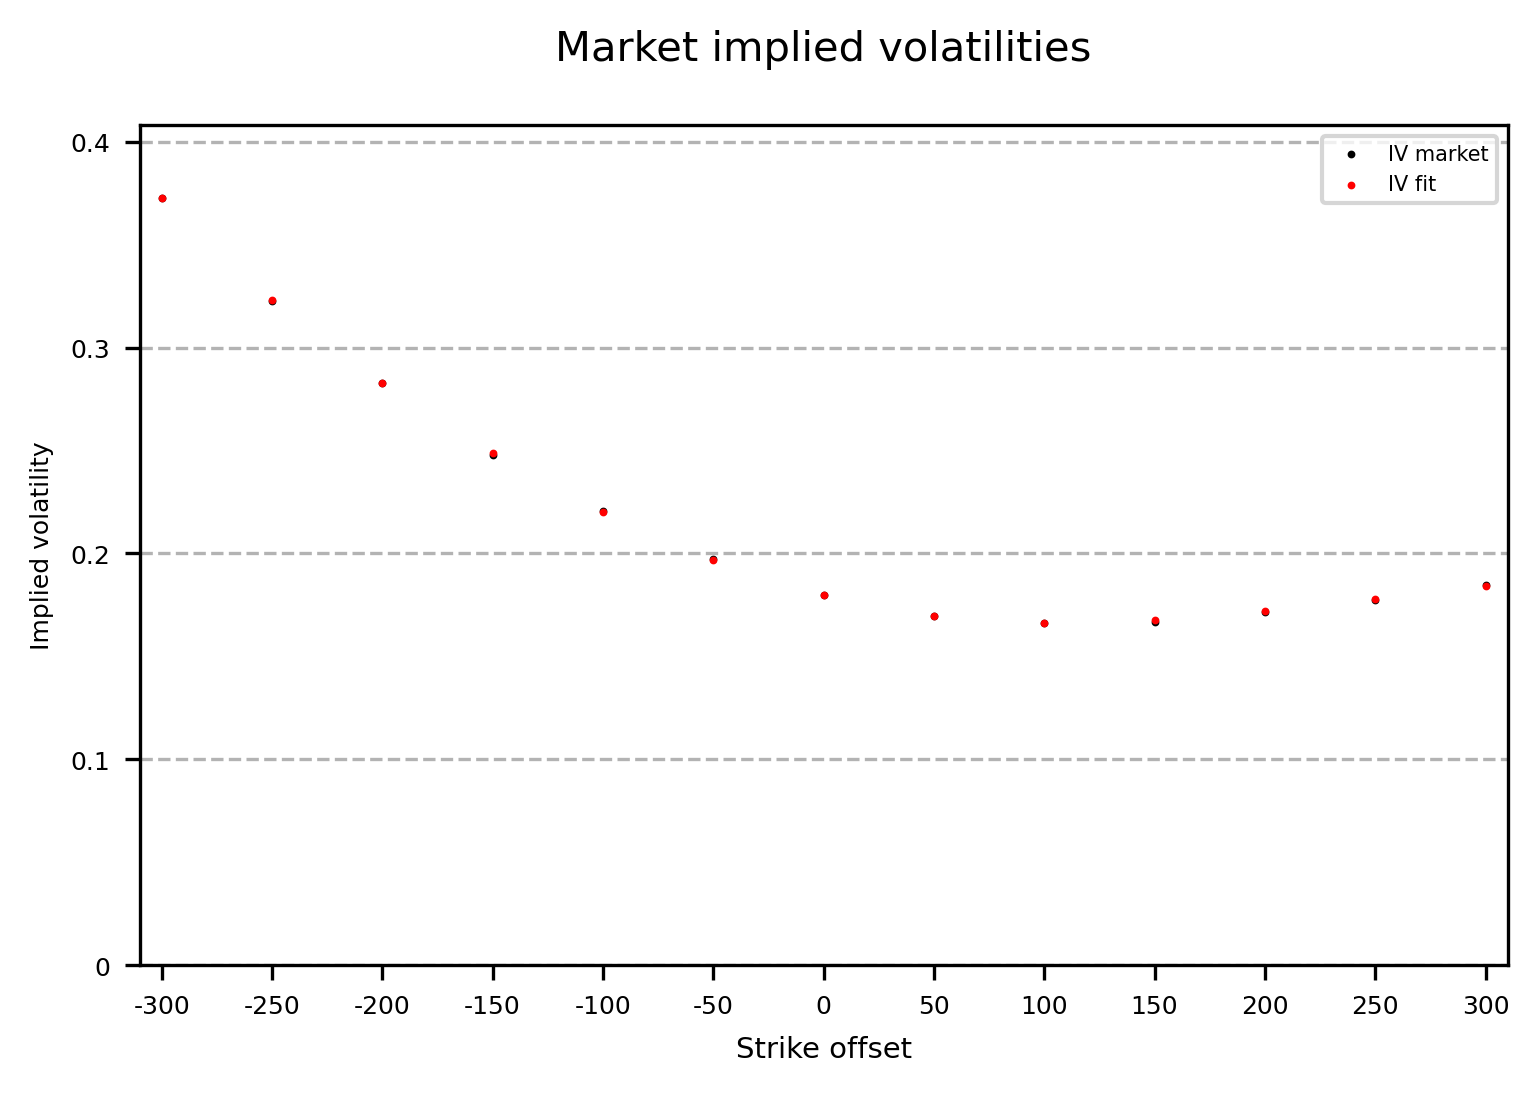

In [10]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))
fig.suptitle(f"Market implied volatilities", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = K_swaption_offset
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-10,xticks[-1]+10])
plt.xlabel(f"Strike offset",fontsize = 7)
ax.set_yticks([0,0.1,0.2,0.3,0.4])
ax.set_yticklabels([0,0.1,0.2,0.3,0.4],fontsize = 6)
ax.set_ylim([0,0.408])
# plt.ylabel(f"Delta",fontsize = 7)
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Implied volatility",fontsize = 6)
p1 = ax.scatter(K_swaption_offset, iv_market, s = 3, color = 'black', marker = ".",label="IV market")
p2 = ax.scatter(K_swaption_offset, iv_fit, s = 3, color = 'red', marker = ".",label="IV fit")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

The fitted values are indeed very close to the observed values which can be seen from the plot.

## Simulating Forward Par Swap Rate

The forward rate, $F_t$, and the volatility $\sigma_t$ can be simulated in the SABR model using a simple Euler scheme. Denote by $M$, the number of steps in the simulation and index the time points in the simulation by $m, m \in\{0,1,2, \ldots, M-1, M\}$ so that the time points will be $\left[t_0, t_1, \ldots, t_{M-1}, t_M\right]=[0, \delta, 2 \delta, \ldots, T-\delta, T=\delta M]$ and hence the step in time will be of size $\delta=\frac{T}{M}$. The model can then be simulated using the following equations
$$
\begin{array}{ll}
F_m=F_{m-1}+\sigma_{m-1} F_{m-1}^\beta \sqrt{\delta} Z_m^{(1)}, & F(0)=F_0 \\
\sigma_m=\sigma_{m-1}+v \sigma_{m-1} \sqrt{\delta}\left(\rho Z_m^{(1)}+\sqrt{1-\rho^2} Z_m^{(2)}\right), & \sigma(0)=\sigma_0
\end{array}
$$
where $Z_m^{(1)}$ and $Z_m^{(2)}$ are independent standard normal random variables.

- For a 2Y5Y forward par swap rate, the longest we can simulate is 2Y as it becomes a spot par swap rate more over the time of exercise has passed! e.g. simulating for 3 years will be a problem if 2Y5Y forward swap rate is fixed.

**Plot the trajectories of the forward par swap rate and the volatility.**

In [35]:
seed = 4  # Plot that looks realistic
#seed = 13 # volatility blows up
#seed = 3  # Volatility goes to 0 14 maybe
#np.random.seed(4)  # Plot that looks realistic
#np.random.seed(13)  # Volatility blows up
#np.random.seed(3)  # Volatility goes to 0 14 maybe
np.random.seed(seed)
T_simul, M_simul = 2, 4_000
F_simul, sigma_simul = fid.sabr_simul(R_swap,sigma_0,beta,upsilon,rho,M_simul,T_simul)
t_simul = np.array([i*T_simul/M_simul for i in range(0,M_simul+1)])

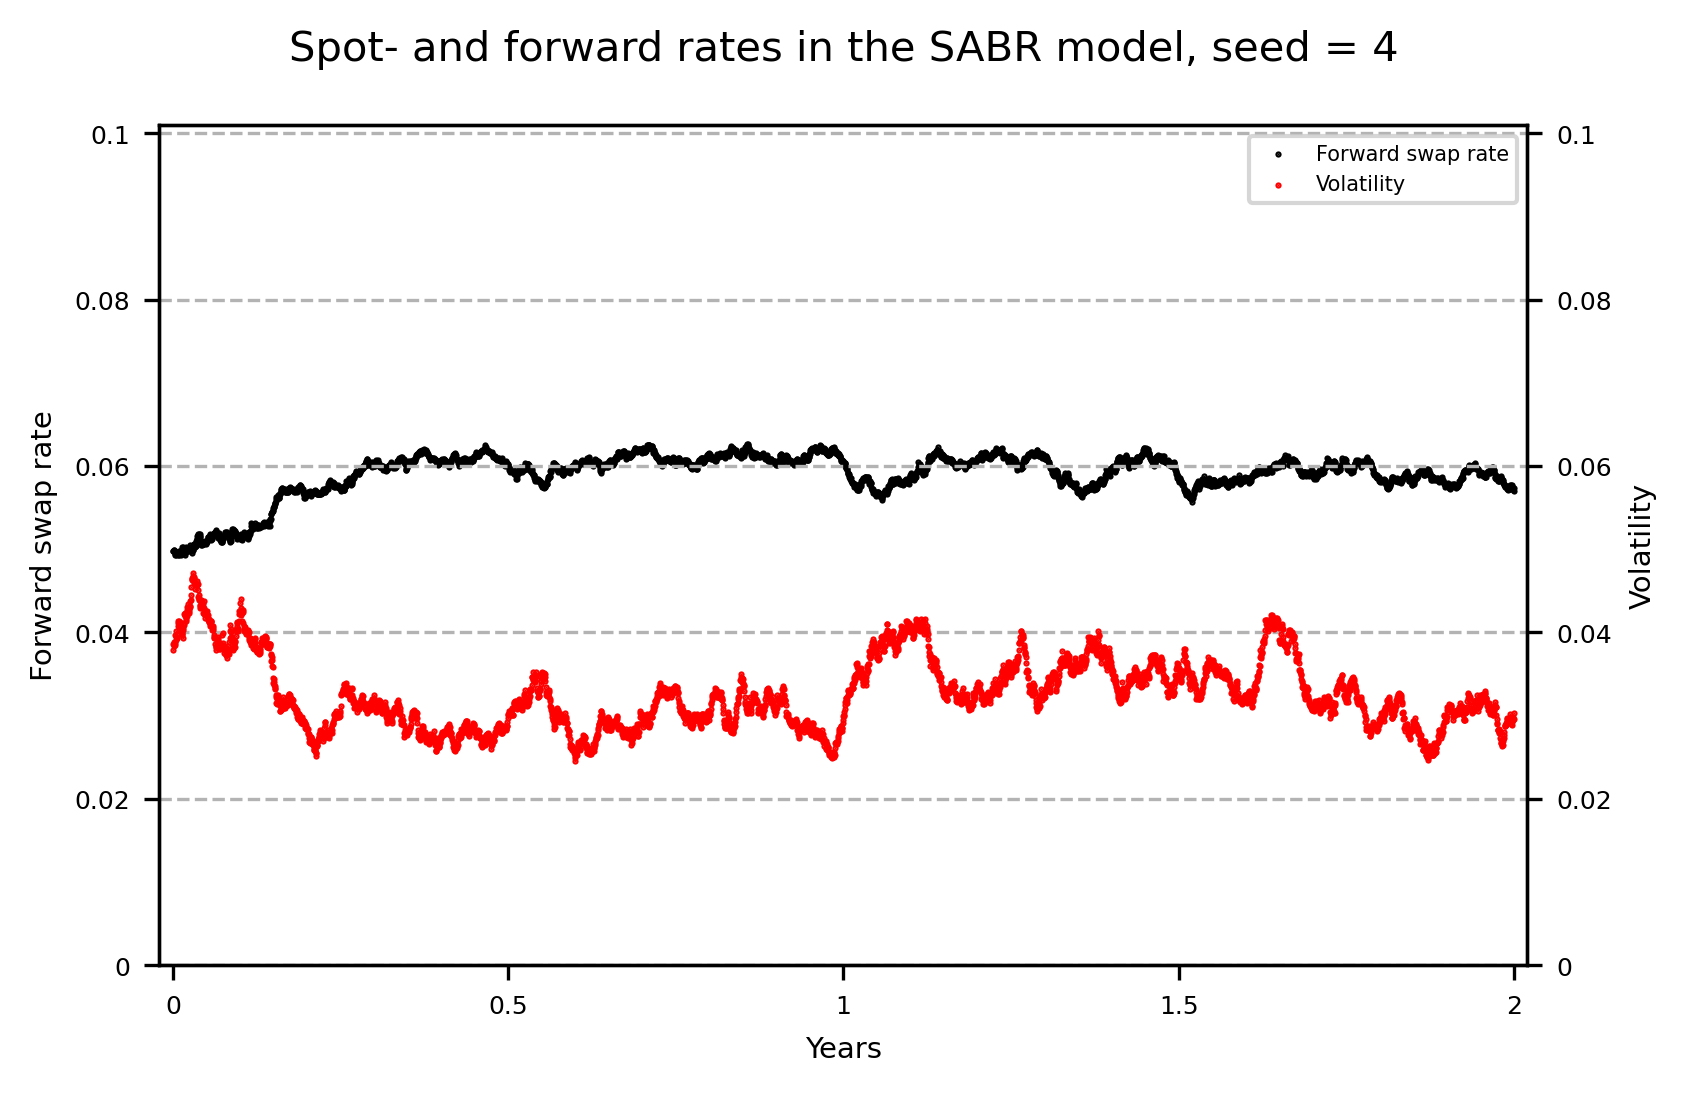

In [36]:
# PLot of simulated values in the SABR model
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))
fig.suptitle(f"Spot- and forward rates in the SABR model, seed = {seed}", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,0.5,1,1.5,2]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.02,xticks[-1]+0.02])
plt.xlabel(f"Years",fontsize = 7)
ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
ax.set_ylim([0,0.101])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
# plt.minorticks_on()
# plt.grid(which='minor', color='grey', linestyle='--')
ax.set_ylabel(f"Forward swap rate",fontsize = 7)
p1 = ax.scatter(t_simul, F_simul, s = 1, color = 'black', marker = ".",label="Forward swap rate")
ax2 = ax.twinx()
ax2.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
ax2.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
ax2.set_ylim([0,0.101])
ax2.set_ylabel(f"Volatility",fontsize = 7)
p2 = ax2.scatter(t_simul, sigma_simul, s = 1, color = 'red', marker = ".",label="Volatility")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

- The first plot for a seed chosen to be 4 , the plot in this case becomes as shown below. In this case, the underlying parswap rate and its volatility both behave relatively realistically.
- Next, we look at the same plot for a seed of 13 . In this case, the volatility 'blows up'.
- Finally, we look at the same plot for a seed of 13 . In this case, volatility 'freezes' at 0 in that at becomes relatively small and can't seem to escape simply because the diffusion coefficient of volatility depends on volatility itself.

### Density Function

In [12]:
# Plotting the density function of the forward rate
T_simul_dens, M_simul_dens, N_simul_dens = 1, 1_000, 6_000
F_simul_dens, sigma_simul_dens = np.zeros([N_simul_dens]), np.zeros([N_simul_dens])
F_simul_temp, sigma_simul_temp = np.zeros([M_simul_dens]), np.zeros([M_simul_dens])
for n in range(0,N_simul_dens):
    F_simul_temp, sigma_simul_temp = fid.sabr_simul(R_swap,sigma_0,beta,upsilon,rho,M_simul_dens,T_simul_dens)
    F_simul_dens[n], sigma_simul_dens[n] = F_simul_temp[-1], sigma_simul_temp[-1]

In [37]:
def vector_to_bins(v,mini,maxi,N):
    v = np.sort(v,kind="heapsort")
    mesh = (maxi-mini)/N
    lb, ub = np.array([mini+i*mesh for i in range(0,N)]), np.array([mini+i*mesh for i in range(1,N+1)])
    y = np.zeros([N])
    i, j, count = 0, 0, 0
    while i < N:
        if v[j] < lb[i]:
            # print(f"A, i: {i}, lb: {lb[i]}, ub: {ub[i]}, j: {j}, v: {v[j]},count: {count}, y: {y}")
            j += 1
        if lb[i] <= v[j] <= ub[i]:
            count += 1
            # print(f"B, i: {i}, lb: {lb[i]}, ub: {ub[i]}, j: {j}, v: {v[j]},count: {count}, y: {y}")
            j += 1
        elif ub[i] < v[j]:
            y[i] = count
            count = 0
            # print(f"C, i: {i}, lb: {lb[i]}, ub: {ub[i]}, j: {j}, v: {v[j]},count: {count}, y: {y}")
            i += 1
        if j > len(v) - 0.5:
            y[i] = count
            i = N
        # print(f"    after", i,lb[i],ub[i],j,v[j],count,y)
    return y, lb, ub

F_bins_N, F_min, F_max = 100, 0.02, 0.08
counts, lb, ub = vector_to_bins(F_simul_dens,F_min,F_max,F_bins_N)
simul_pmf = counts/sum(counts)
bins = 0.5*(lb + ub)
sigma = iv_market[int((N_swaption-1)/2)]*np.sqrt(T_simul_dens)
mu = np.log(R_swap) - 0.5*sigma**2
black_pmf = np.zeros([F_bins_N])
for i in range(0,F_bins_N):
    black_pmf[i] = ndtr(((np.log(ub[i])-mu))/sigma) - ndtr(((np.log(lb[i])-mu))/sigma)
print(f"mu: {mu}, sigma: {sigma}")

mu: -3.015247617271764, sigma: 0.17974193063442895


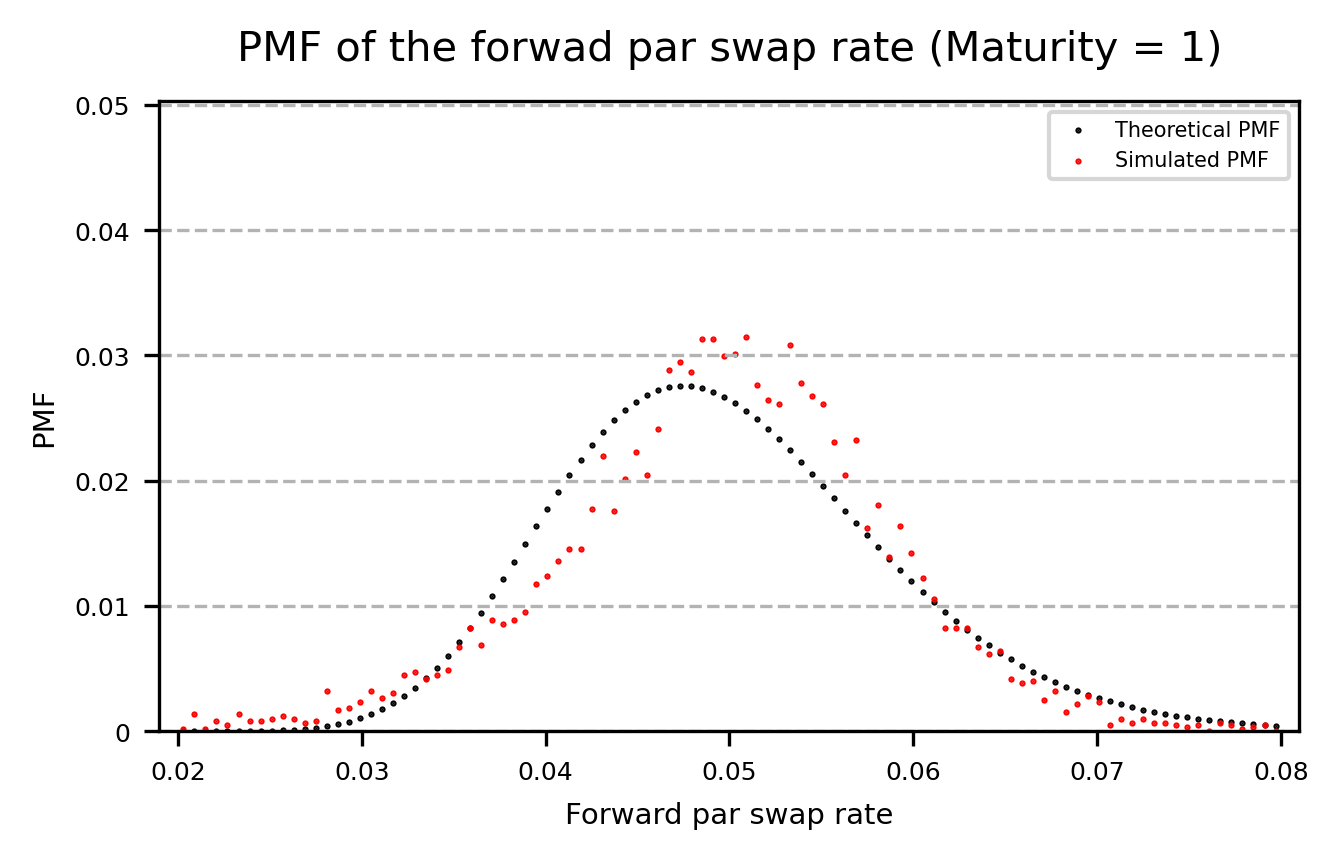

In [38]:
# Plot of simulated and theoretical density of the forward par swap rate
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"PMF of the forwad par swap rate (Maturity = {T_simul_dens})", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0.02,0.03,0.04,0.05,0.06,0.07,0.08]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.001,xticks[-1]+0.001])
ax.set_xlabel(f"Forward par swap rate",fontsize = 7)
ax.set_yticks([0,0.01,0.02,0.03,0.04,0.05])
ax.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05],fontsize = 6)
ax.set_ylim([0,0.0503])
ax.set_ylabel(f"PMF",fontsize = 7)
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
# plt.minorticks_on()
# plt.grid(which='minor', color='grey', linestyle='--')
p1 = ax.scatter(bins, black_pmf, s = 1, color = 'black', marker = ".",label="Theoretical PMF")
p2 = ax.scatter(bins, simul_pmf, s = 1, color = 'red', marker = ".",label="Simulated PMF")
# plt.axvline(x=R_swap)
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

### Spot and Forward Rates

In [15]:
r0, a, b, sigma_vasicek = 0.025, 0.5, 0.025, 0.02
R = fid.spot_rate_vasicek(r0,a,b,sigma_vasicek,T)
p = fid.spot_rates_to_zcb(T,R)
L = fid.zcb_to_forward_LIBOR_rates(T,p,horizon = 1)

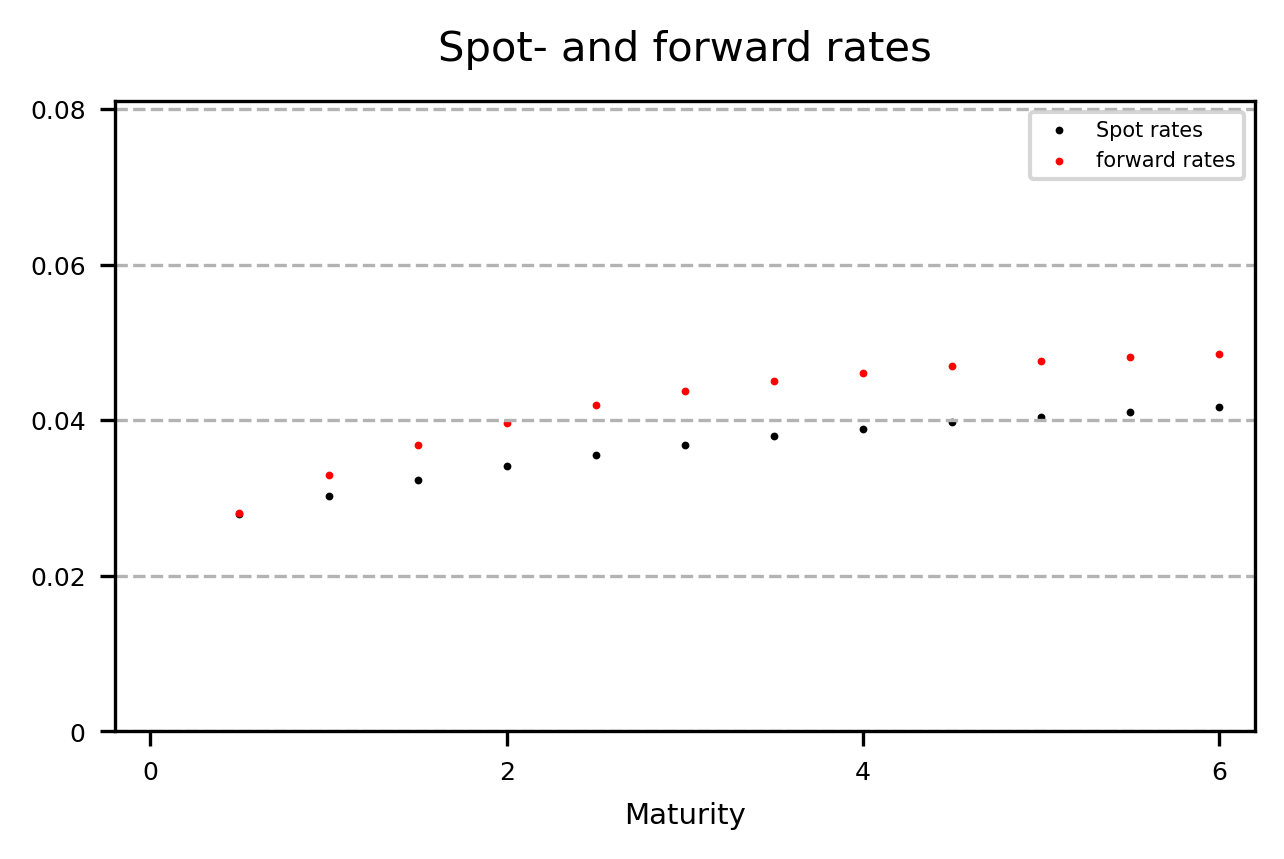

In [16]:
# PLot of spot and forward rates
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))
fig.suptitle(f"Spot- and forward rates", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 7)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.081])
# plt.ylabel(f"Delta",fontsize = 7)
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T[1:], R[1:], s = 3, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T[1:], L[1:], s = 3, color = 'red', marker = ".",label="forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
plt.show()

## Digital Options

Now, we will compute the price of a digital option in the SABR model. The digital option will be one that pays 1 unit of currency if the $5 \mathrm{Y}$ spot swap rate in exactly two years exceeds the $2 \mathrm{Y} 5 \mathrm{Y}$ forward par swap rate observed right now +75 bps. So we have a strike $K=F_0+0.0075$)

**i) Which measure is the SABR model defined under? And how does that affect your ability to compute the price of a maturity $T=2$ derivative such as the digital option considered here. What can you do if you have to price a derivative with a different maturity?**

The SABR model is defined under the forward measure, specifically the forward measure corresponding to the maturity of the underlying swaption. If we denote the maturity of the swaption by $T$, the SABR model is in other words defined under the measure $\mathbb{Q}^T$, the measure under which all assets scaled by the price $p(t, T)$ of the maturity $T$ ZCB are martingales. This is fact is important because it implies that we can discount future cashflows back to time 0 using the price $p(t, T)$ that we can observe from market prices. If we were to price other a derivative with a different maturity, we would need to either switch to the forward measure corresponding to that new maturity or use an entirely different model.

$$
\pi(t)=E^Q\left[e^{-\int_0^T r_s d s} \chi(x)\right]=p(t, T) E^{Q^T}[\chi(x)]=p\left(t, T_n\right) E^{Q^T n}\left[1_{F_{T_n}>K}\right]=p(t, T) Q^{T_n}\left(F_{T_n}>K\right)
$$

- Where $T_n$ is time of exercise. So we can simulate the probability that the underlying $F$ at exercise is greater than strike $\mathrm{K}$ (atm forward rate + 75 bps). Where estimated probability is simply fraction of times where F_T_n is above K using simulation and then multply by the time zero price of 1 unit of currency delivered at exercise time.

**ii) Find the payoff function $\chi(T)$ and the discounted payoff function for the digital option.**

The payoff function $\chi(T)$ and the discounted payoff function $\tilde{\chi}(T)$ for the digital option are
$$
\begin{aligned}
& \chi(T)=\mathbb{1} R_2^5(2)>K \\
& \tilde{\chi}(T)=p(0,2) \mathbb{1} R_2^5(2)>K
\end{aligned}
$$
where $R_2^5(2)$ is the $5 \mathrm{Y}$ par swap rate in exactly 2 years when the digital option matures.

**iii) The digital option requires many simulation for price pricing, but choosing $M=4,000$ timesteps and $N=100,000$ simulations, the price in this case became 0.2364.**

- We don't have what investor wants but we can synthetize!
- This will not protect against huge market sell of due to interest rates rising, because the payoff is capped.

In [ ]:
M_simul, T_digital = 4_000, 2
N_simul = 100_000
strike = R_swap + 75/10_000
F_simul, sigma_simul = np.zeros([M_simul]), np.zeros([M_simul])
frac_ITM = np.zeros([N_simul])
count = 0
for n in range(0,N_simul):
    F_simul, sigma_simul = fid.sabr_simul(R_swap, sigma_0, beta, upsilon, rho, M_simul, T_digital)
    if F_simul[-1] > strike:
        count += 1
    frac_ITM[n] = count/(n+1)
print(f"frac ITM: {frac_ITM[-1]}, price = {p[4]*frac_ITM[-1]}") # likelihood that ITM*P(0,2)
idx_conv_check = np.array([i*int(N_simul/10) - 1 for i in range(1,11)])
for idx in idx_conv_check:
    print(f"idx: {idx},frac_ITM: {frac_ITM[idx]}")

## Hedging in SABR

We can hedge in SABR against parameter changes, which can be due to rho, sigma and spot curve:
- say you have shift in market from right to left tail, i.e. rho changing, which would not be good if invested in right tail swaption. So we can ask what is our exposure to rho. Or what happens if sigma falls?
- If sigma falls, the payoff falls as well. If you sit on a call option, you would want variation (a lot of volatility, i.e. a change that underlying blows up), resulting in a lot of money! But it can at worse case expire worthless (deep out-themoney).
- You can be afected by change in spot curve which affects the underlying! Say fall, The value of position falls as chance of finishing in the money goes down!

Imagine you have a long position in the $K_{\text {offset }}=150$ $2\mathrm{Y} 5\mathrm{Y}$ payer swaption and you need to assess how you are exposed to changes in the SABR model parameters. Do this by computing the change in dollar value (DV) in the following cases.

**What happens if $\sigma_0$ falls by 0.001?**

Computing the change in the value of the long position in a payer swaption if $\sigma_0$ changes:
1) recompute the implied volatility for the new value of $\sigma_0$ 
2) then use Black's formula for the value of a payer swaption.

In [11]:
# identify position
idx_position = 9 # position of K_offset = 150

# Bumping sigma_0
sigma_0_bump = sigma_0 - 0.001

# recompute implied volatility 
iv_sigma_0 = fid.sigma_sabr(K[idx_position],T[idx_exer],R_swap,sigma_0_bump,beta,upsilon,rho,type = "call")
# use Black's formula to value payer swaption
price_sigma_0 = fid.black_swaption_price(iv_sigma_0,T[idx_exer],K[idx_position],S_swap,R_swap,type = "call")
print(f"price after bumping sigma_0: {price_sigma_0}, diff: {price_sigma_0-price_market[idx_position]}")

price after bumping sigma_0: 0.003391768360399918, diff: -0.00022505163960008208


The value of the payer swaption falls by roughly 2.25 if $\sigma_0$ falls by 0.001.

**What Happens if spot rate curve falls by 0.001?**

**Cookbook**
1) We need to first bump the entire spot rate curve
2) then recompute the $2 \mathrm{Y} 5 \mathrm{Y}$ forward par swap rate 
3) then recompute the price of the payer swaption using Black's formula

In [14]:
# Bumping the entire spot rate curve
R = fid.zcb_to_spot_rates(T,p)
R_bump = R - 0.0001*np.ones([M])
p_bump = fid.spot_rates_to_zcb(T,R_bump)
S_bump = 0
for i in range(idx_exer+1,idx_mat + 1):
    S_bump += alpha*p_bump[i]
R_swap_bump = (p_bump[idx_exer] - p_bump[idx_mat])/S_bump
sigma_delta = fid.sigma_sabr(K[idx_position],T[idx_exer],R_swap_bump,sigma_0,beta,upsilon,rho,type = "call")
price_delta = fid.black_swaption_price(sigma_delta,T[idx_exer],K[idx_position],S_bump,R_swap_bump,type = "call")
print(f"price after bumping spot rates: {price_delta}, diff: {price_delta-price_market[idx_position]} in percent :{(price_delta-price_market[idx_position])/price_market[idx_position]}")

price after bumping spot rates: 0.0036085167002569587, diff: -8.303299743041455e-06 in percent :-0.0022957459157606558


We get that the value of the payer swaption drops by $0.083033 \mathrm{bps}$ if the entire spot curve drops by one bp. The change in value corresponds to a drop of roughly 0.2 percent.